# Capstone 2: West Nile Virus Prediction

# Initial Data Cleaning

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [2]:
train = pd.read_csv("train.csv", parse_dates=True)
weather = pd.read_csv("weather.csv", parse_dates=True)

In [3]:
train.shape

(10506, 12)

In [4]:
weather.shape

(2944, 22)

In [45]:
train.head(10)

,Date,Species,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,9,1,0
1,2007-05-29,CULEX RESTUANS,41,N OAK PARK AVE,T002,41.954690,-87.800991,9,1,0
2,2007-05-29,CULEX RESTUANS,62,N MANDELL AVE,T007,41.994991,-87.769279,9,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,8,1,0
4,2007-05-29,CULEX RESTUANS,79,W FOSTER AVE,T015,41.974089,-87.824812,8,4,0
5,2007-05-29,CULEX RESTUANS,15,W WEBSTER AVE,T045,41.921600,-87.666455,8,2,0
6,2007-05-29,CULEX RESTUANS,25,W GRAND AVE,T046,41.891118,-87.654491,8,1,0
7,2007-05-29,CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,1,0
8,2007-05-29,CULEX RESTUANS,11,W ROOSEVELT,T048,41.867108,-87.654224,8,2,0
9,2007-05-29,CULEX RESTUANS,11,W CHICAGO,T049,41.896282,-87.655232,8,1,0


In [6]:
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [7]:
weather.head(2)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6


In [8]:
weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


In [9]:
def fill_Tavg(x1,x2,x3):
    if pd.isnull(x3):
        x3=np.ceil((x1+x2)/2)
        return x3
    else:
        return x3
def calc_decadent_normal(x1,x2):
    if pd.isnull(x2):
        return np.nan
    else:
        return int(x1)-int(x2)
    

In [10]:
#filling NAs and dropping unneeded columns. FFill method used for missing values as asssociated columns have very similar values
weather=weather.replace('-', np.nan)
weather=weather.replace('M', np.nan)
median_speed = weather['AvgSpeed'].median()
weather['AvgSpeed'] = weather['AvgSpeed'].fillna(value=median_speed)

col = ['Sunrise', 'WetBulb', 'Sunset', 'Heat', 'Cool','SeaLevel','StnPressure']

for x in col: 
    weather[x] = weather[x].fillna(method='ffill')

weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0.00 if str(x).strip()=='T' or pd.isnull(x) else x)
weather['PrecipBool'] = weather['PrecipTotal'].apply(lambda x: 'N' if x=='0.00' else 'Y')
weather['Tavg']=weather.apply(lambda x: fill_Tavg(x['Tmax'], x['Tmin'], x['Tavg']), axis=1)
weather['decadent_normal']=weather.apply(lambda x: calc_decadent_normal(x['Tavg'], x['Depart']), axis=1)
weather['decadent_normal']=weather['decadent_normal'].fillna(method='ffill')
weather['Depart']=weather.apply(lambda x: int(x['Tavg'])-int(x['decadent_normal']), axis=1)

weather=weather.drop(['decadent_normal'], axis=1)
weather=weather.drop(['Water1','Depth', 'SnowFall', 'CodeSum'], axis=1)
train = train.drop(['Address', 'AddressNumberAndStreet'], axis = 1)


In [11]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
PrecipBool     0
dtype: int64

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             10506 non-null  object 
 1   Species          10506 non-null  object 
 2   Block            10506 non-null  int64  
 3   Street           10506 non-null  object 
 4   Trap             10506 non-null  object 
 5   Latitude         10506 non-null  float64
 6   Longitude        10506 non-null  float64
 7   AddressAccuracy  10506 non-null  int64  
 8   NumMosquitos     10506 non-null  int64  
 9   WnvPresent       10506 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 820.9+ KB


In [13]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   int64  
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  PrecipTotal  2944 non-null   object 
 13  StnPressure  2944 non-null   object 
 14  SeaLevel     2944 non-null   object 
 15  ResultSpeed  2944 non-null   float64
 16  ResultDir    2944 non-null   int64  
 17  AvgSpeed     2944 non-null   object 
 18  PrecipBool   2944 non-null   object 
dtypes: flo

# Rahul, how do I average/merge weather data without having it drop columns automatically? StnPressure dropped below.

In [14]:
#Finding average of weather data between the two stations by date
weather = weather.drop("Station", axis = 1)
average = weather.groupby("Date").mean()
average.sort_values("Date", ascending = True)
average['Tavg'] = (average['Tmax'] + average['Tmin'])/2
tmp = average.pop("Tavg")
average.insert(2, "Tavg", tmp)

In [125]:
merged = train.join(average, on='Date')

In [129]:
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

def create_year(x): 
    return x.split('-')[0]

merged['month'] = merged.Date.apply(create_month)
merged['day'] = merged.Date.apply(create_day)
merged['year']=merged.Date.apply(create_year)
merged.drop('Date', axis = 1, inplace = True)

In [130]:
#Finding the streets with the highest virus concentration
x = merged.groupby(['year','Block','Street'])['WnvPresent'].sum()
y = merged.groupby(['year','Block','Street'])['Street'].count()

z = pd.concat([x,y], axis=1)
z['% Count'] = np.round(x/y,4)*100

z.index.rename(['Year','Block','StreetName'],inplace=True)
z.reset_index(inplace=True, )
z.set_index(['Block','StreetName'], inplace=True)
z.rename({'Stree':'Strt_Rec_Cnt'}, inplace=True)
z[z['% Count']>0].sort_values(by=['Year','% Count'], ascending=[True,False])

,,Year,WnvPresent,Street,% Count
Block,StreetName,,,,
40,E 130TH ST,2007,5,24,20.83
36,N PITTSBURGH AVE,2007,7,35,20.00
50,S UNION AVE,2007,6,30,20.00
65,N OAK PARK AVE,2007,6,31,19.35
72,N OKETO AVE,2007,7,39,17.95
...,...,...,...,...,...
10,E 67TH ST,2013,1,27,3.70
62,N MCCLELLAN AVE,2013,1,27,3.70
17,W ADDISON ST,2013,1,29,3.45


/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


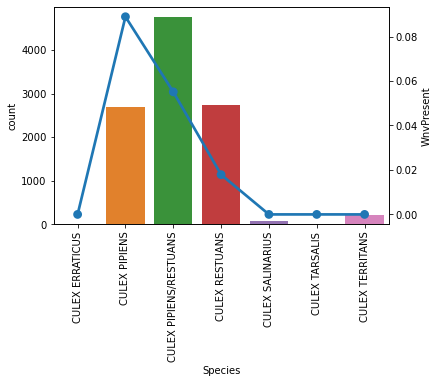

In [131]:
#Determining which species has the highest rate of the virus. What's unclear is whether the "Cullex Pipens/Restauns"
# is a hybrid species or a data error where they didn't know if it was a culex pipiens or a restauns
species = pd.crosstab(train['Species'],train['WnvPresent'],normalize='index')
species.reset_index(drop=True)
species.columns = ['WnvAbsent','WnvPresent']

fig,ax = plt.subplots(1,1)
g = sns.countplot(train['Species'], ax=ax, order = list(species.index))
ax.tick_params(axis='x',rotation=90)
g2 = g.twinx()
sns.pointplot(species.index, species['WnvPresent'], ax=g2, order = list(species.index))
plt.show()

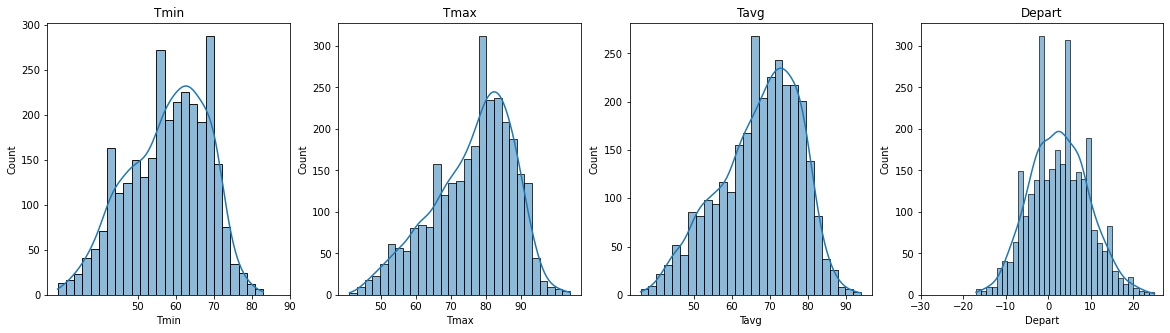

In [132]:
#Determining the effect of temperature
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.histplot(weather['Tmin'], ax=ax[0], kde = True)
ax[0].xaxis.set(ticks=np.arange(50,100,10))
ax[0].set_title('Tmin')


sns.histplot(weather['Tmax'], ax=ax[1], kde = True)
ax[1].xaxis.set(ticks=np.arange(50,100,10))
ax[1].set_title('Tmax')

sns.histplot(weather['Tavg'].apply(int), ax=ax[2], kde = True)
ax[2].xaxis.set(ticks=np.arange(50,100,10))
ax[2].set_title('Tavg')

sns.histplot(weather['Depart'].apply(int), ax=ax[3], kde = True)
ax[3].xaxis.set(ticks=np.arange(-30,30,10))
ax[3].set_title('Depart')

plt.show()

/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


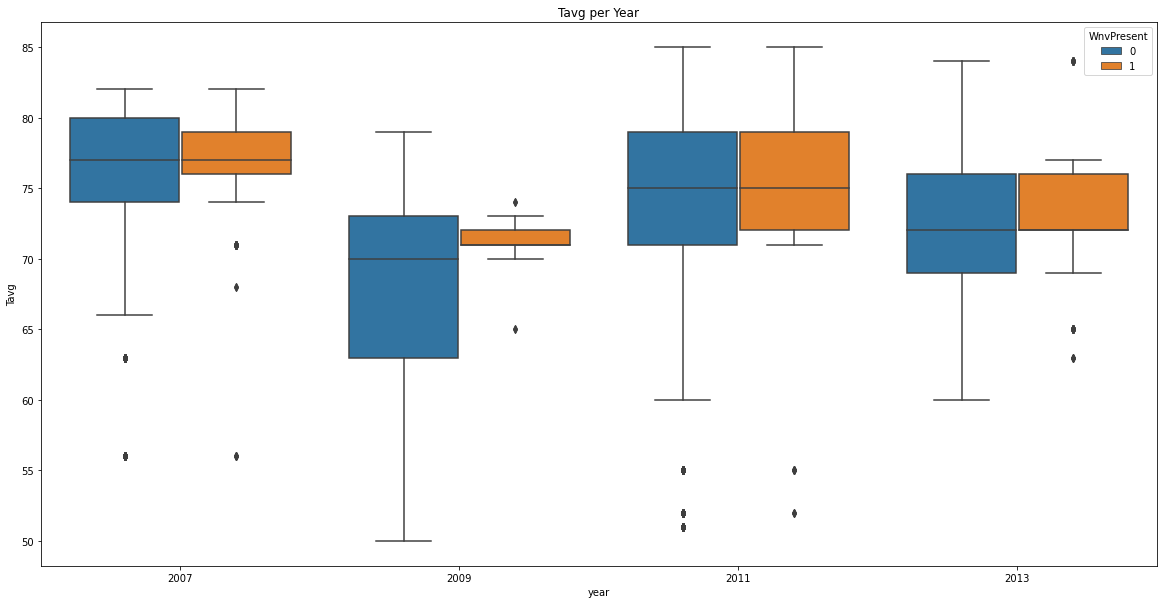

In [133]:
# A box plot of the Tavg each year shows that both warmer years and less volatile temperature differences
# during said year typically produced more WNV cases.
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.boxplot(merged['year'],merged['Tavg'].apply(int), hue = merged['WnvPresent'], ax=ax)
ax.set_title('Tavg per Year')
plt.show()

In [146]:
#The following 'Weight of Evidence' and 'Information Value' techniques were copied from:
#https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb#:~:text=Weight%20of%20evidence%20(WOE)%20and,the%20logistic%20regression%20modeling%20technique

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [147]:
final_iv, IV = data_vars(merged, merged.WnvPresent)

/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/b2/h4qnkctx6ts90k0f6nt21pj80000gn/T/ipykernel_85467/774458303.py:15: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
/var/folders/b2/h4qnkctx6ts90k0f6nt21pj80000gn/T/ipykernel_85467/774458303.py:15: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
/var/folders/b2/h4qnkctx6ts90k0f6nt21pj80000gn/T/ipykernel_854

AttributeError: module 'pandas.core.algorithms' has no attribute 'quantile'

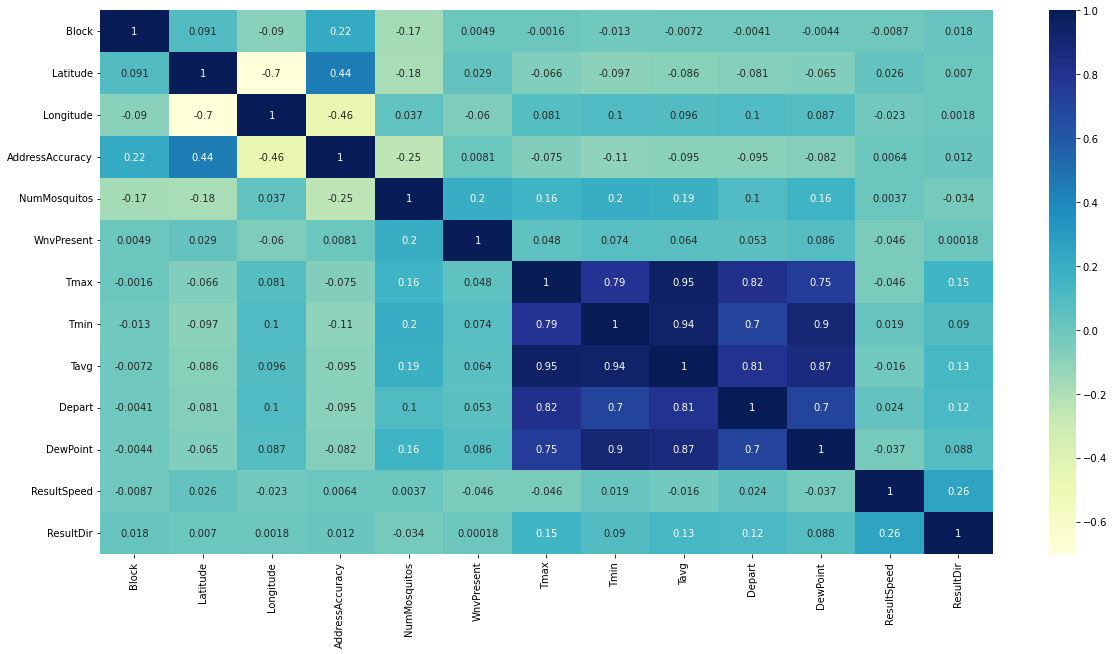

In [23]:
#Strongest relationships between Tmax, Tmin, Depart and DewPoint (expected for weather)
#
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(merged.corr(), annot=True, cmap="YlGnBu" ,ax = ax)
plt.show()

In [24]:
#Getting dummies

df = pd.get_dummies(merged, columns = ['Species', 'month', 'day', 'year'])
df

,Block,Street,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Tmax,Tmin,...,day_26,day_27,day_28,day_29,day_30,day_31,year_2007,year_2009,year_2011,year_2013
0,41,N OAK PARK AVE,T002,41.954690,-87.800991,9,1,0,88.0,62.5,...,0,0,0,1,0,0,1,0,0,0
1,41,N OAK PARK AVE,T002,41.954690,-87.800991,9,1,0,88.0,62.5,...,0,0,0,1,0,0,1,0,0,0
2,62,N MANDELL AVE,T007,41.994991,-87.769279,9,1,0,88.0,62.5,...,0,0,0,1,0,0,1,0,0,0
3,79,W FOSTER AVE,T015,41.974089,-87.824812,8,1,0,88.0,62.5,...,0,0,0,1,0,0,1,0,0,0
4,79,W FOSTER AVE,T015,41.974089,-87.824812,8,4,0,88.0,62.5,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,51,W 72ND ST,T035,41.763733,-87.742302,8,6,1,75.0,52.5,...,1,0,0,0,0,0,0,0,0,1
10502,58,N RIDGE AVE,T231,41.987280,-87.666066,8,5,0,75.0,52.5,...,1,0,0,0,0,0,0,0,0,1
10503,17,N ASHLAND AVE,T232,41.912563,-87.668055,9,1,0,75.0,52.5,...,1,0,0,0,0,0,0,0,0,1
10504,71,N HARLEM AVE,T233,42.009876,-87.807277,9,5,0,75.0,52.5,...,1,0,0,0,0,0,0,0,0,1


In [25]:
x= df.groupby(['Block'])['Street'].nunique().sort_values(ascending=False)
print(x)

Block
10    9
11    9
22    6
17    4
40    4
     ..
41    1
43    1
45    1
46    1
98    1
Name: Street, Length: 64, dtype: int64
